In [1]:
import pandas as pd
import numpy as np
import os
import json
import re
from hashlib import sha512
from vega import VegaLite
from wordcloud import WordCloud
from IPython.display import display

def display_vg(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v2+json'] = spec
    display(bundle, raw=True)
    
def mkdir(directory):
    """
    :param string directory: 
    :return: 
    """
    try:
        os.mkdir(directory)
    except FileExistsError:
        pass
    
def save_file(file_name, data):
    with open(file_name, "w") as f:
        f.write(data)
        

In [2]:
mkdir("../data/generated/")
mkdir("../data/generated/images")

In [3]:
def get_modules(root):
    modules = [item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item))]
    
    return modules

modules = get_modules("../data/raw/modules")

modules

['CSC-10032']

In [4]:
module = "CSC-10032"
print(module)
# mkdir("../data/generated/images/{0}".format(module))

output = {}
output["module_code"] = module

def get_grades(module):
    file = '../data/raw/modules/{0}/grades.csv'.format(module)
    with open(file, "r") as f:
        fline = f.readline()
        assessment_weights = [int(weight)/100 for weight in re.findall(r"\((.*?)%\)", fline)]
        
    grades = pd.read_csv(file, skiprows=[0])
    grades = grades[['#Ass#', 'Mark', '#Cand Key']]
    grades.columns = ['ass', 'grade', 'user']
#     grades['user'] = grades['user'].str.replace(r'#|/[0-9]', '').apply(lambda u: sha512(u.encode('utf-8')).hexdigest())
    grades['user'] = grades['user'].str.replace(r'#|/[0-9]', '').astype('int')
    grades = grades.set_index('user')

    assessments = grades['ass'].unique()
    module_grades = pd.DataFrame([], index=grades.index.unique())

    for k, ass in enumerate(assessments):
        assessment_grades = grades[grades['ass'] == ass]['grade'].to_frame()
        assessment_grades.columns = [ass]
        assessment_grades['{0}_weighted'.format(ass)] = assessment_grades[ass] * assessment_weights[k]
        module_grades = module_grades.merge(assessment_grades, left_index=True, right_index=True, how="outer")

    module_grades = module_grades.fillna(0)
    module_grades['final_grade'] = module_grades.filter(regex="_weighted").sum(axis=1)
    
    return module_grades, assessment_weights

def get_year_and_semester(module):
    file = '../data/raw/modules/{0}/grades.csv'.format(module)
    grades = pd.read_csv(file, skiprows=[0])
    
    return (grades.iloc[0]['Year'], grades.iloc[0]['Period'])

year, semester = get_year_and_semester(module)
output["year"] = year
output["semester"] = re.sub(r"SEM", "", semester)
module_grades, weights = get_grades(module)

output["num_students"] = module_grades.shape[0]
print(weights)
module_grades.head()

CSC-10032
[0.5, 0.5]


,#01,#01_weighted,#02,#02_weighted,final_grade
user,,,,,
13015197,0.0,0.0,0.0,0.0,0.0
14011845,86.0,43.0,83.0,41.5,84.5
15010954,72.0,36.0,62.0,31.0,67.0
15011855,34.0,17.0,67.0,33.5,50.5
15014342,73.0,36.5,91.0,45.5,82.0


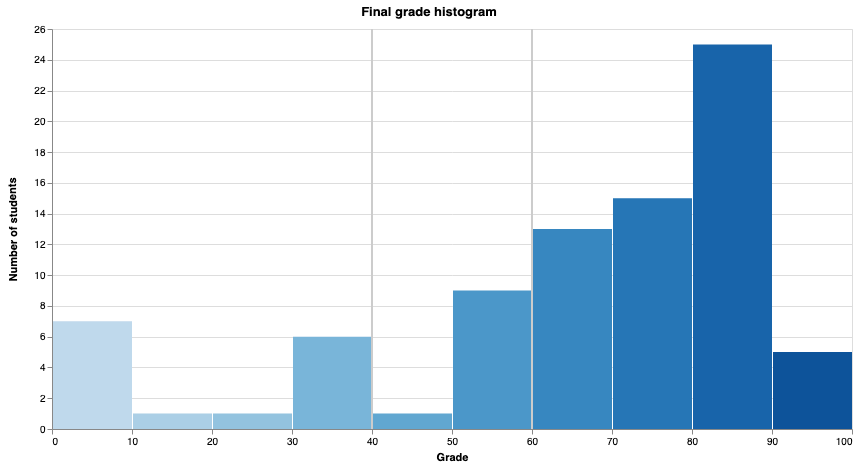

In [5]:
height = 400
width = 800

def build_grade_histogram(height, width, data, grade_field, title):
    return VegaLite({
        "$schema": "https://vega.github.io/schema/vega-lite/v2.0.json",
        "title": title,
        "height": height,
        "width": width,
        "layer": [
            {
                "mark": "bar",
                "encoding": {
                    "x": {
                        "bin": { "step": 10 },
                        "field": grade_field,
                        "type": "quantitative",
                        "axis": { "title": "Grade", "tickCount": 10 },
                        "scale": { "domain": [0, 100]}
                    },
                    "y": {
                        "aggregate": "count",
                        "type": "quantitative",
                        "axis": { "title": "Number of students" }
                    },
                    "color": {
                        "bin": { "step": 10 },
                        "field": grade_field,
                        "type": "quantitative",
                        "legend": None
                    }
                }
            },
            {
                "mark": "rule",
                "encoding": {
                    "x": {
                        "value": width/100 * 40
                    },
                    "size": {
                        "value": 2
                    },
                    "color": {
                        "value": "#ccc"
                    }
                }
            },
            {
                "mark": "rule",
                "encoding": {
                    "x": {
                        "value": width/100 * 60
                    },
                    "size": {
                        "value": 2
                    },
                    "color": {
                        "value": "#ccc"
                    }
                }
            }
        ]
    }, data)

chart = build_grade_histogram(height, width, module_grades, "final_grade", "Final grade histogram")
output["hist"] = chart.spec

display_vg(chart.spec)

In [6]:
def get_grade_stats(grades):
    stats = {}
    stats["median"] = round(grades['final_grade'].median(), 1)
    stats["gte70"] = int(grades[grades['final_grade'] >= 70]['final_grade'].count())
    stats["gte60"] = int(grades[grades['final_grade'] >= 60]['final_grade'].count() - stats["gte70"])
    stats["lte40"] = int(grades[grades['final_grade'] <= 40]['final_grade'].count())
    stats["zeros"] = int(grades[grades['final_grade'] == 0]['final_grade'].count())

    return stats

output["stats"] = get_grade_stats(module_grades)

output["stats"]

{'median': 71.0, 'gte70': 45, 'gte60': 13, 'lte40': 15, 'zeros': 7}

In [7]:
all_grades = [get_grades(module)[0]["final_grade"] for module in modules]
average_grades = pd.DataFrame(pd.concat(all_grades, axis=1).mean(axis=1), columns=["average_grade"])
# random averages
# average_grades = pd.DataFrame((np.random.random_sample(module_grades.shape[0]) * 100).round(1), columns=["average_grade"], index=module_grades.index)
compare_grades = module_grades.merge(average_grades, left_index=True, right_index=True, how="left")

compare_grades.head()

,#01,#01_weighted,#02,#02_weighted,final_grade,average_grade
user,,,,,,
13015197,0.0,0.0,0.0,0.0,0.0,0.0
14011845,86.0,43.0,83.0,41.5,84.5,84.5
15010954,72.0,36.0,62.0,31.0,67.0,67.0
15011855,34.0,17.0,67.0,33.5,50.5,50.5
15014342,73.0,36.5,91.0,45.5,82.0,82.0


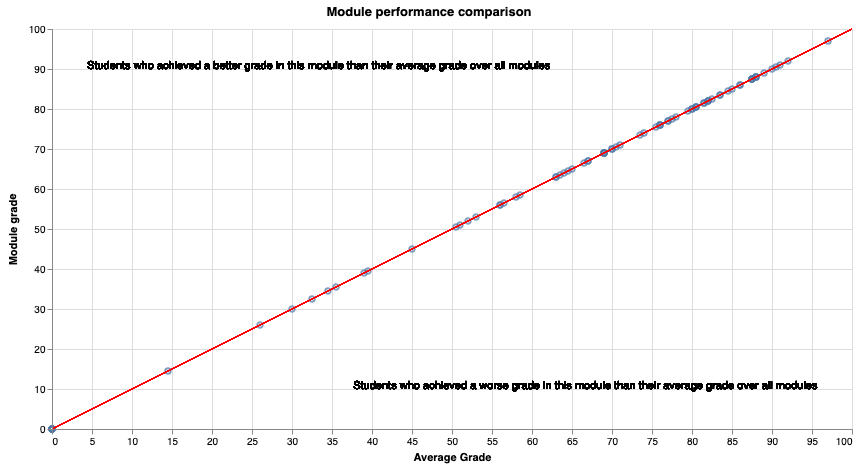

In [8]:
def build_grade_comparison_plot(height, width, data):
    return VegaLite({
        "$schema": "https://vega.github.io/schema/vega-lite/v2.0.json",
        "title": "Module performance comparison",
        "height": height,
        "width": width,
        "layer": [
            {
                "mark": "point",
                "encoding": {
                    "x": {
                        "field": "average_grade",
                        "type": "quantitative",
                        "axis": { "title": "Average Grade" },
                        "scale": { "domain": [0, 100]}
                    },
                    "y": {
                        "field": "final_grade", 
                        "typs": "quantitative",
                        "axis": { "title": "Module grade" },
                        "scale": { "domain": [0, 100]}
                    }
                }
            },
            {
                "mark": "rule",
                "encoding": {
                    "x": {
                        "value": 0
                    },
                    "y": {
                        "value": height
                    },
                    "size": {
                        "value": 1
                    },
                    "color": {
                        "value": "red"
                    }
                }
            },
            {
                "mark": "text",
                "encoding": {
                    "x": {
                        "value": width / 3
                    },
                    "y": {
                        "value": height / 10
                    },
                    "text": {
                        "value": "Students who achieved a better grade in this module than their average grade over all modules",
                    },
                }
            },
            {
                "mark": "text",
                "encoding": {
                    "x": {
                        "value": width - (width / 3)
                    },
                    "y": {
                        "value": height - (height / 10)
                    },
                    "text": {
                        "value": "Students who achieved a worse grade in this module than their average grade over all modules",
                    },
                }
            }
        ]
    }, data)
        
chart = build_grade_comparison_plot(height, width, compare_grades)
output["compare"] = chart.spec

display_vg(chart.spec)

## Learning analytics data

In [17]:
def get_la_data(module):
    file = '../data/raw/modules/{0}/la.csv'.format(module)
    la = pd.read_csv(file)
    la['STU_ID'] = la['STU_ID'].astype('int')
    la_mean_per_user = la.drop(['USER', 'WK'], axis=1).groupby(['STU_ID']).sum()
#     la_mean_per_user['ACC_MEAN_DUR_WK0'] =  la_mean_per_user['ACC_MEAN_DUR_WK0'].apply(lambda x: x/12)
    la_mean_per_user = la_mean_per_user.apply(lambda x: x/12)
    la_mean_per_week = la.drop(['STU_ID', 'USER'], axis=1).groupby(['WK']).mean().reset_index()
    
    return la_mean_per_user, la_mean_per_week

lapu, lapw = get_la_data(module)
lapu.head()

,ACC_TOT_WK0,ACC_DUR_WK0,ACC_MEAN_DUR_WK0,ACC_COUNT_WK0,C_GRP_Coursework_WK0,C_GRP_Lectures_WK0,C_GRP_Practicals_WK0,ABS_WK0,LC_TOT
STU_ID,,,,,,,,,
15011855,3.083333,17.730567,2.532938,0.666667,1.000000,0.083333,0.333333,0.333333,0.000000
15014342,7.416667,30.965267,4.493318,1.250000,1.083333,0.750000,1.333333,0.166667,0.166667
16011881,7.166667,15.426375,2.216532,1.250000,1.500000,0.166667,1.166667,0.083333,0.000000
16012442,14.083333,27.998625,4.210287,2.583333,1.750000,1.916667,2.416667,0.166667,0.166667
16014883,7.916667,21.277792,3.039685,1.250000,1.500000,0.166667,1.833333,0.000000,0.166667


In [35]:
def build_la_line_chart(height, width, data, field, title):
    return VegaLite({
        "$schema": "https://vega.github.io/schema/vega-lite/v2.0.json",
        "title": title,
        "height": height,
        "width": width,
        "layer": [
            {
                "mark": "line",
                "encoding": {
                    "x": {
                        "field": 'WK',
                        "type": "quantitative",
                        "axis": { "title": "Week", "tickCount": 12 },
                    },
                    "y": {
                        "field": field,
                        "type": "quantitative",
                        "axis": { "title": field }
                    }
                }
            },
            {
                "mark": "point",
                "encoding": {
                    "x": {
                        "field": "WK",
                        "type": "quantitative",
                    },
                    "y": {
                        "field": field,
                        "type": "quantitative",
                    }
                }
            }
        ]
    }, data)

chart = build_la_line_chart(height, width, lapw, "ACC_MEAN_DUR_WK0", "Total clicks per week")
output["la_line"] = chart.spec

# display_vg(chart.spec)
[col for col in lapw.drop(['WK'], axis=1).columns]

['ACC_TOT_WK0',
 'ACC_DUR_WK0',
 'ACC_MEAN_DUR_WK0',
 'ACC_COUNT_WK0',
 'C_GRP_Coursework_WK0',
 'C_GRP_Lectures_WK0',
 'C_GRP_Practicals_WK0',
 'ABS_WK0',
 'LC_TOT']

In [25]:
def get_la_vs_grades(la, grades):
    merged = la.merge(grades, how="left", left_index=True, right_index=True)
    
    return merged

cs = get_la_vs_grades(lapu, module_grades)
cs.head()

,ACC_TOT_WK0,ACC_DUR_WK0,ACC_MEAN_DUR_WK0,ACC_COUNT_WK0,C_GRP_Coursework_WK0,C_GRP_Lectures_WK0,C_GRP_Practicals_WK0,ABS_WK0,LC_TOT,#01,#01_weighted,#02,#02_weighted,final_grade
STU_ID,,,,,,,,,,,,,,
15011855,37,212.7668,2.532938,8,12,1,4,4,0,34.0,17.0,67.0,33.5,50.5
15014342,89,371.5832,4.493318,15,13,9,16,2,2,73.0,36.5,91.0,45.5,82.0
16011881,86,185.1165,2.216532,15,18,2,14,1,0,51.0,25.5,53.0,26.5,52.0
16012442,169,335.9835,4.210287,31,21,23,29,2,2,58.0,29.0,80.0,40.0,69.0
16014883,95,255.3335,3.039685,15,18,2,22,0,2,55.0,27.5,83.0,41.5,69.0


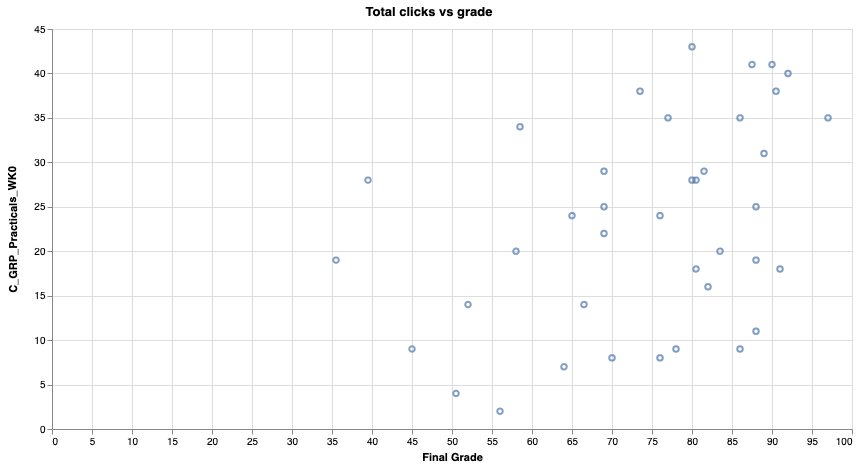

In [13]:
def build_la_grade_comparison_plot(height, width, data, field, title):
    return VegaLite({
        "$schema": "https://vega.github.io/schema/vega-lite/v2.0.json",
        "title": title,
        "height": height,
        "width": width,
        "layer": [
            {
                "mark": "point",
                "encoding": {
                    "x": {
                        "field": "final_grade",
                        "type": "quantitative",
                        "axis": { "title": "Final Grade" },
                        "scale": { "domain": [0, 100]}
                    },
                    "y": {
                        "field": field,
                        "type": "quantitative",
                        "axis": { "title": field }
                    }
                }
            }
        ]
    }, data)
        
chart = build_la_grade_comparison_plot(height, width, cs, "C_GRP_Practicals_WK0", "Total clicks vs grade")
output["compare"] = chart.spec

display_vg(chart.spec)

## Multiple choice questions

In [14]:
mc_options = [
    "Strongly Agree",
    "Agree",
    "Disagree",
    "Strongly Disagree",
    "N/A"
]

def get_student_multi_choice_feedback(module, answers):
    fb = pd.read_csv("../data/raw/modules/{0}/feedback.csv".format(module))
    fbq = pd.DataFrame(fb.filter(regex=r"^\d\.", axis=1))
    fbq = fbq.drop(fbq.columns[len(fbq.columns)-2:], axis=1)

    fb_answers = pd.DataFrame(fbq.apply(pd.value_counts))
    answers = pd.DataFrame(answers, columns=["answer"])
    answers = pd.DataFrame(answers).merge(fb_answers, left_on="answer", right_index=True, how="left").fillna(0)
    answers.columns = ["answer"] + ["q{0}".format(i+1) for i in range(len(fbq.columns))]
    
    return fbq.columns.tolist(), answers

sfbq, sfba = get_student_multi_choice_feedback(module, mc_options)

sfba

,answer,q1,q2,q3,q4,q5,q6,q7
0,Strongly Agree,14.0,9.0,9.0,8.0,6.0,8.0,9.0
1,Agree,13.0,18.0,17.0,16.0,17.0,17.0,16.0
2,Disagree,0.0,0.0,0.0,1.0,4.0,1.0,2.0
3,Strongly Disagree,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,N/A,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Additional comments for multiple choice questions

In [15]:
def get_textual_student_feedback(module):
    fb = pd.read_csv("../data/raw/modules/{0}/feedback.csv".format(module))
    fb = fb.filter(regex=r"additional comments", axis=1)
    
    text_fb = []
    for col in fb:
        text_fb.append(fb[col].dropna().drop_duplicates().tolist())
    
    return text_fb
    
get_textual_student_feedback(module)

[[],
 [],
 [],
 ['It was really interesting to see the actual work/ interests of the lecturers themselves',
  'I already have a lot of experience in the subjects discussed in the lectures, but staff made it very interesting and engaging anyway.'],
 ['Much better on average than the other modules',
  'To me, the practicals are more of a place to force myself to work efficiently, rather than procrastinate the work, and the fact that I can ask questions doing it make the practicals very useful'],
 [],
 []]

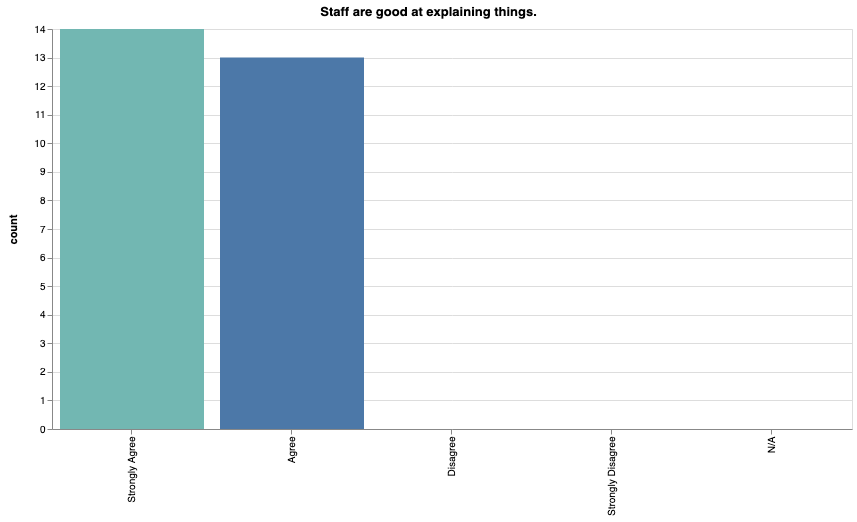

In [16]:
def build_student_feedback_histogram(height, width, data, questions, question):
    return VegaLite({
        "$schema": "https://vega.github.io/schema/vega-lite/v2.0.json",
        "title": re.sub(r"\d.\s", "", questions[question-1]),
        "height": height,
        "width": width,
        "mark": "bar",
        "encoding": {
            "x": {
                "field": "answer",
                "type": "nominal",
                "sort": None,
                "axis": { "title": "" }
            },
            "y": {
                "field": "q{0}".format(question),
                "type": "quantitative",
                "axis": { "title": "count" }
            },
            "color": {
                "field": "answer",
                "type": "nominal",
                "legend": None,
            }
        }
    }, data)

chart = build_student_feedback_histogram(height, width, sfba, sfbq, 1)
output["feedback"] = chart.spec

display_vg(chart.spec)

## Descriptive questions

In [17]:
def get_descriptive_student_feedback(module):
    fb = pd.read_csv("../data/raw/modules/{0}/feedback.csv".format(module))
    fb = fb.drop(fb.columns[0:-2], axis=1)

    desc_fb = []
    for col in fb:
        desc_fb.append(fb[col].dropna())

    return fb.columns.tolist(), desc_fb
    
dfbq, dfba = get_descriptive_student_feedback(module)
dfba

[0                                           Most things
 1         Interesting topics delivered by great speaker
 2                                                     -
 3     Lectures are presented in an interesting and e...
 5              Learning about Web Design in more detail
 6                                                  Html
 7     I enjoyed learning about the different element...
 8     The engagement made with the class makes it fe...
 9                                             Lectures 
 10                                           HTML intro
 11                                              Nothing
 12                           Lectures were really good.
 13                                         The lectures
 14       How passionate the lecturer is about this area
 15    I appreciated that the module has playback as ...
 16     Straight forward lessons with clear information 
 17                        The lecture on accessibility 
 18           The sections on g

In [18]:
def build_word_cloud(text):
    return WordCloud(background_color="black", colormap="GnBu", height=height, width=width, font_path="../fonts/caveat.ttf").generate(text)

try:
    wordcloud = build_word_cloud(dfba[0].str.cat(sep=" "))
    wordcloud.to_image()
    # wordcloud.to_file("../data/generated/images/{0}/{1}.png".format(module, desc_questions[0][0]))
except(ValueError):
    print("wordcloud could not be created")

## Staff feedback

In [14]:
def get_staff_feedback(module):
    fb = pd.read_csv("../data/raw/staff-feedback.csv")
    mfb = fb[fb["Module Code"] == module]
    if len(mfb) < 1:
        return None
    return mfb.drop(["Timestamp", "Email address", "Module Code", "Module Name"], axis=1).iloc[0].to_dict()

staff_fb = get_staff_feedback(module)

output["staff_feedback"] = staff_fb
staff_fb

{'Are you planning to make a minor amendment to your module?': 'No.',
 'Do you have any further comments?': 'No.',
 'Do you have any good practice that you would like to share?': 'None that I have not shared in previous module reviews.',
 'Module tutor(s)': 'Martyn Parker',
 'What, in your opinion, could be improved (including details of planned changes for next year)?': 'This module will no longer run. Next year a new year-long 30 credit module replaces both Investigations and Problem Solving (IPS) and Applicable Mathematics (AM). This new module combines elements of the two old 15 credit modules. \n\n1) The new 30 credit module will provide more time for formative work aligned to the summative assessments. There will be greater emphasis on producing electronic mathematics using suitable computer packages.\n\n2) The journals will be reworked to adapt the current 4Rs reflective module and the use of PebblePad to record student reflections aligned to the KUSP.\n\n3) Although the new 30 

In [15]:
# save_file("../data/generated/{0}.json".format(module), json.dumps(output))
# output